### Kütüphaneler

In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms 
import torchvision
import os
import pandas as pd
from torch.utils.data import (Dataset,DataLoader) 
from skimage import io
import time

import warnings
warnings.filterwarnings("ignore")

### Veriyi Dahil Etme

In [2]:
class veri(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        if self.transform:
            image = self.transform(image)
            
        return (image, y_label)

### Veriyi Hazırlama

In [3]:
dataset = veri(csv_file = r"f113.csv",
              root_dir = r"f1_classification",
              transform = transforms.Compose([
                  transforms.ToTensor(),
                  #transforms.ToPILImage(mode=None),
                  transforms.Resize(size = (600, 600)),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

### Veri Ön İşleme

In [4]:
train_set,  test_set = torch.utils.data.random_split(dataset, [200,79]) 
train_loader = DataLoader(dataset=train_set, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=False)

### Veriyi Görselleştirme

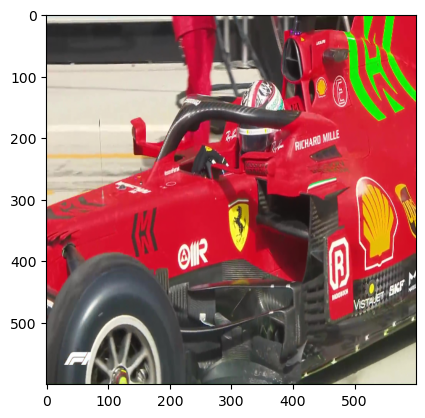

Ferrari
torch.Size([1, 3, 600, 600])


In [5]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 1
classes = ["Ferrari", "Mclaren", "Mercedes", "Redbull"]

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2,0)))
    plt.show()
    
    
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(" ".join("%5s" % classes[labels[j]] for j in range(batch_size)))
print(images.size())

### Modeli Yükleme

In [6]:
model = torchvision.models.googlenet(pretrained=False)

In [7]:
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [8]:
model.fc = nn.Linear(in_features=1024, out_features=4, bias=True)

In [9]:
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

### Modelin Eğitimi ve Doğruluğu

In [10]:
start = time.time()

optimizer = optim.Adam(model.parameters(), lr=0.001)
error = nn.CrossEntropyLoss()

epoch = 10
count = 0
loss_list = []
iteration_list = []

for i in range(epoch):
    for i, (images, label) in enumerate(train_loader):
        
        out = model(images)
        optimizer.zero_grad()
        
        loss = error(out[1], label)
        
        loss.backward()
        
        optimizer.step()
        count+=1
        
        if count % 100 == 0:
            total = 0
            correct = 0
            correct_hata = 0
            
            for images, labels in test_loader:
                
                out = model(images.float())
                
                y_pred = torch.max(out[1].data, 1)[1]
                
                total+=len(labels)
                
                correct += (y_pred == labels).sum()
                correct_hata += (y_pred != labels).sum()
                
            accuracy = 100 * correct / float(total)
            hata = 100 * correct_hata / float(total)
            
            loss_list.append(loss.data)                
            iteration_list.append(count)
            
        if count % 100 ==0:
            print("İterasyon: {} loss:{} Accuracy: {}% Error: {}%".format(count, loss.data, accuracy, hata))


end = time.time()
print("süre: ", end-start)

İterasyon: 100 loss:1.4594666957855225 Accuracy: 20.253164291381836% Error: 79.74683380126953%
İterasyon: 200 loss:1.798231601715088 Accuracy: 29.113924026489258% Error: 70.88607788085938%
İterasyon: 300 loss:4.570768356323242 Accuracy: 21.51898765563965% Error: 78.48101043701172%
İterasyon: 400 loss:0.061882905662059784 Accuracy: 49.367088317871094% Error: 50.632911682128906%
İterasyon: 500 loss:0.04221373423933983 Accuracy: 37.97468185424805% Error: 62.02531814575195%
İterasyon: 600 loss:0.1420210301876068 Accuracy: 54.43037796020508% Error: 45.56962203979492%
İterasyon: 700 loss:0.012056335806846619 Accuracy: 48.10126495361328% Error: 51.89873504638672%
İterasyon: 800 loss:0.011100560426712036 Accuracy: 45.56962203979492% Error: 54.43037796020508%
İterasyon: 900 loss:0.13942237198352814 Accuracy: 48.10126495361328% Error: 51.89873504638672%
İterasyon: 1000 loss:0.15666121244430542 Accuracy: 60.75949478149414% Error: 39.24050521850586%
İterasyon: 1100 loss:0.07864867150783539 Accurac